In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import scipy.stats

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms, models
import tqdm

from ray import tune


import autonomous_optimizer
import benchmark

Convex quadratics

In [162]:
problem_size = 500

problem = benchmark.convex_quadratic(problem_size)
model0, obj_function, optimal_x, optimal_value, A, b = problem["model0"], problem["obj_function"],
    problem["optimal_x"], problem["optimal_value"], problem["A"], problem["b"]
    
print(f'Objective function minimum: {optimal_value}')

iterations = 1000

IndentationError: unexpected indent (<ipython-input-162-4b40cdb230f4>, line 5)

Tune algo hyperparams on convex quadratic with Bayesian optimization

In [4]:
quadratic_tune = benchmark.tune_algos(
    x0,
    obj_function,
    iterations,
    tune_iters=20,
    hyperparam_space={
        "lr": tune.loguniform(1e-5, 5e-1),
        "momentum": tune.uniform(0.7, 1),
        "delta": tune.uniform(0, 40)
    },
    algos=["sgd", "momentum", "adam"]
)

print('Final hyperparam values:')
for algo, results in quadratic_tune.items():
    print(f'  {algo}: ')
    for hp, val in results['hyperparams'].items():
        print(f'    {hp}: {val}')

  0%|          | 0/3 [00:00<?, ?it/s]2020-11-25 19:09:10,017	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265
2020-11-25 19:09:12,083	WARNING function_runner.py:540 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2020-11-25 19:09:19,294	INFO tune.py:439 -- Total run time: 10.78 seconds (7.19 seconds for the tuning loop).
100%|██████████| 3/3 [00:25<00:00,  8.45s/it]

Final hyperparam values:
  sgd: 
    lr: 0.09869977211422105
  momentum: 
    nesterov: True
    lr: 0.08764610093675615
    momentum: 0.8854386210638834
  adam: 
    lr: 0.0028453928986611663


Run algos with our tuned hyperparams

In [5]:
# SGD
sgd_quadratic_vals, sgd_quadratic_traj = benchmark.run_optimizer(
    torch.optim.SGD, x0, obj_function, iterations, quadratic_tune['sgd']['hyperparams'])
print(f'SGD optimality gap: {sgd_quadratic_vals.min() - optimal_value}')

# Momentum
momentum_quadratic_vals, momentum_quadratic_traj = benchmark.run_optimizer(
    torch.optim.SGD, x0, obj_function, iterations, quadratic_tune['momentum']['hyperparams'])
print(f'Momentum optimality gap: {momentum_quadratic_vals.min() - optimal_value}')

# Adam
adam_quadratic_vals, adam_quadratic_traj = benchmark.run_optimizer(
    torch.optim.Adam, x0, obj_function, iterations, quadratic_tune['adam']['hyperparams'])
print(f'Adam optimality gap: {adam_quadratic_vals.min() - optimal_value}')

# Autonomous optimizer
#ao_quadratic_vals, ao_quadratic_traj = benchmark.run_optimizer(
#    autonomous_optimizer.AutonomousOptimizer, x0, obj_function, iterations, {})
#print(f'Autonomous Optimizer optimality gap: {ao_quadratic_vals.min() - optimal_value}')

SGD optimality gap: 0.0003490106901153922
Momentum optimality gap: -4.423782229423523e-09
Adam optimality gap: 0.3471406487515196


Distance from optimal vs iteration

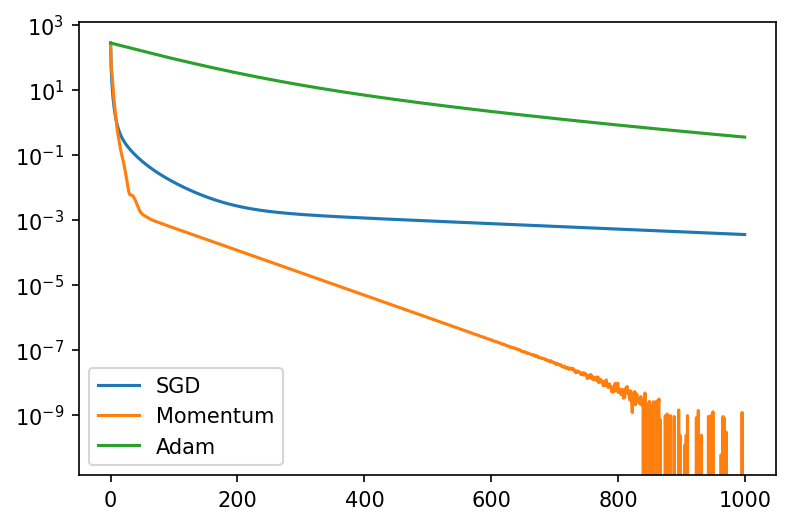

In [6]:
plt.figure(figsize=(6, 4), dpi=150)

plt.plot(sgd_quadratic_vals - optimal_value, label='SGD')
plt.plot(momentum_quadratic_vals - optimal_value, label='Momentum')
plt.plot(adam_quadratic_vals - optimal_value, label='Adam')

plt.yscale('log')
plt.legend()
plt.show()

Plotting trajectories on a 2-D slice of the parameter space

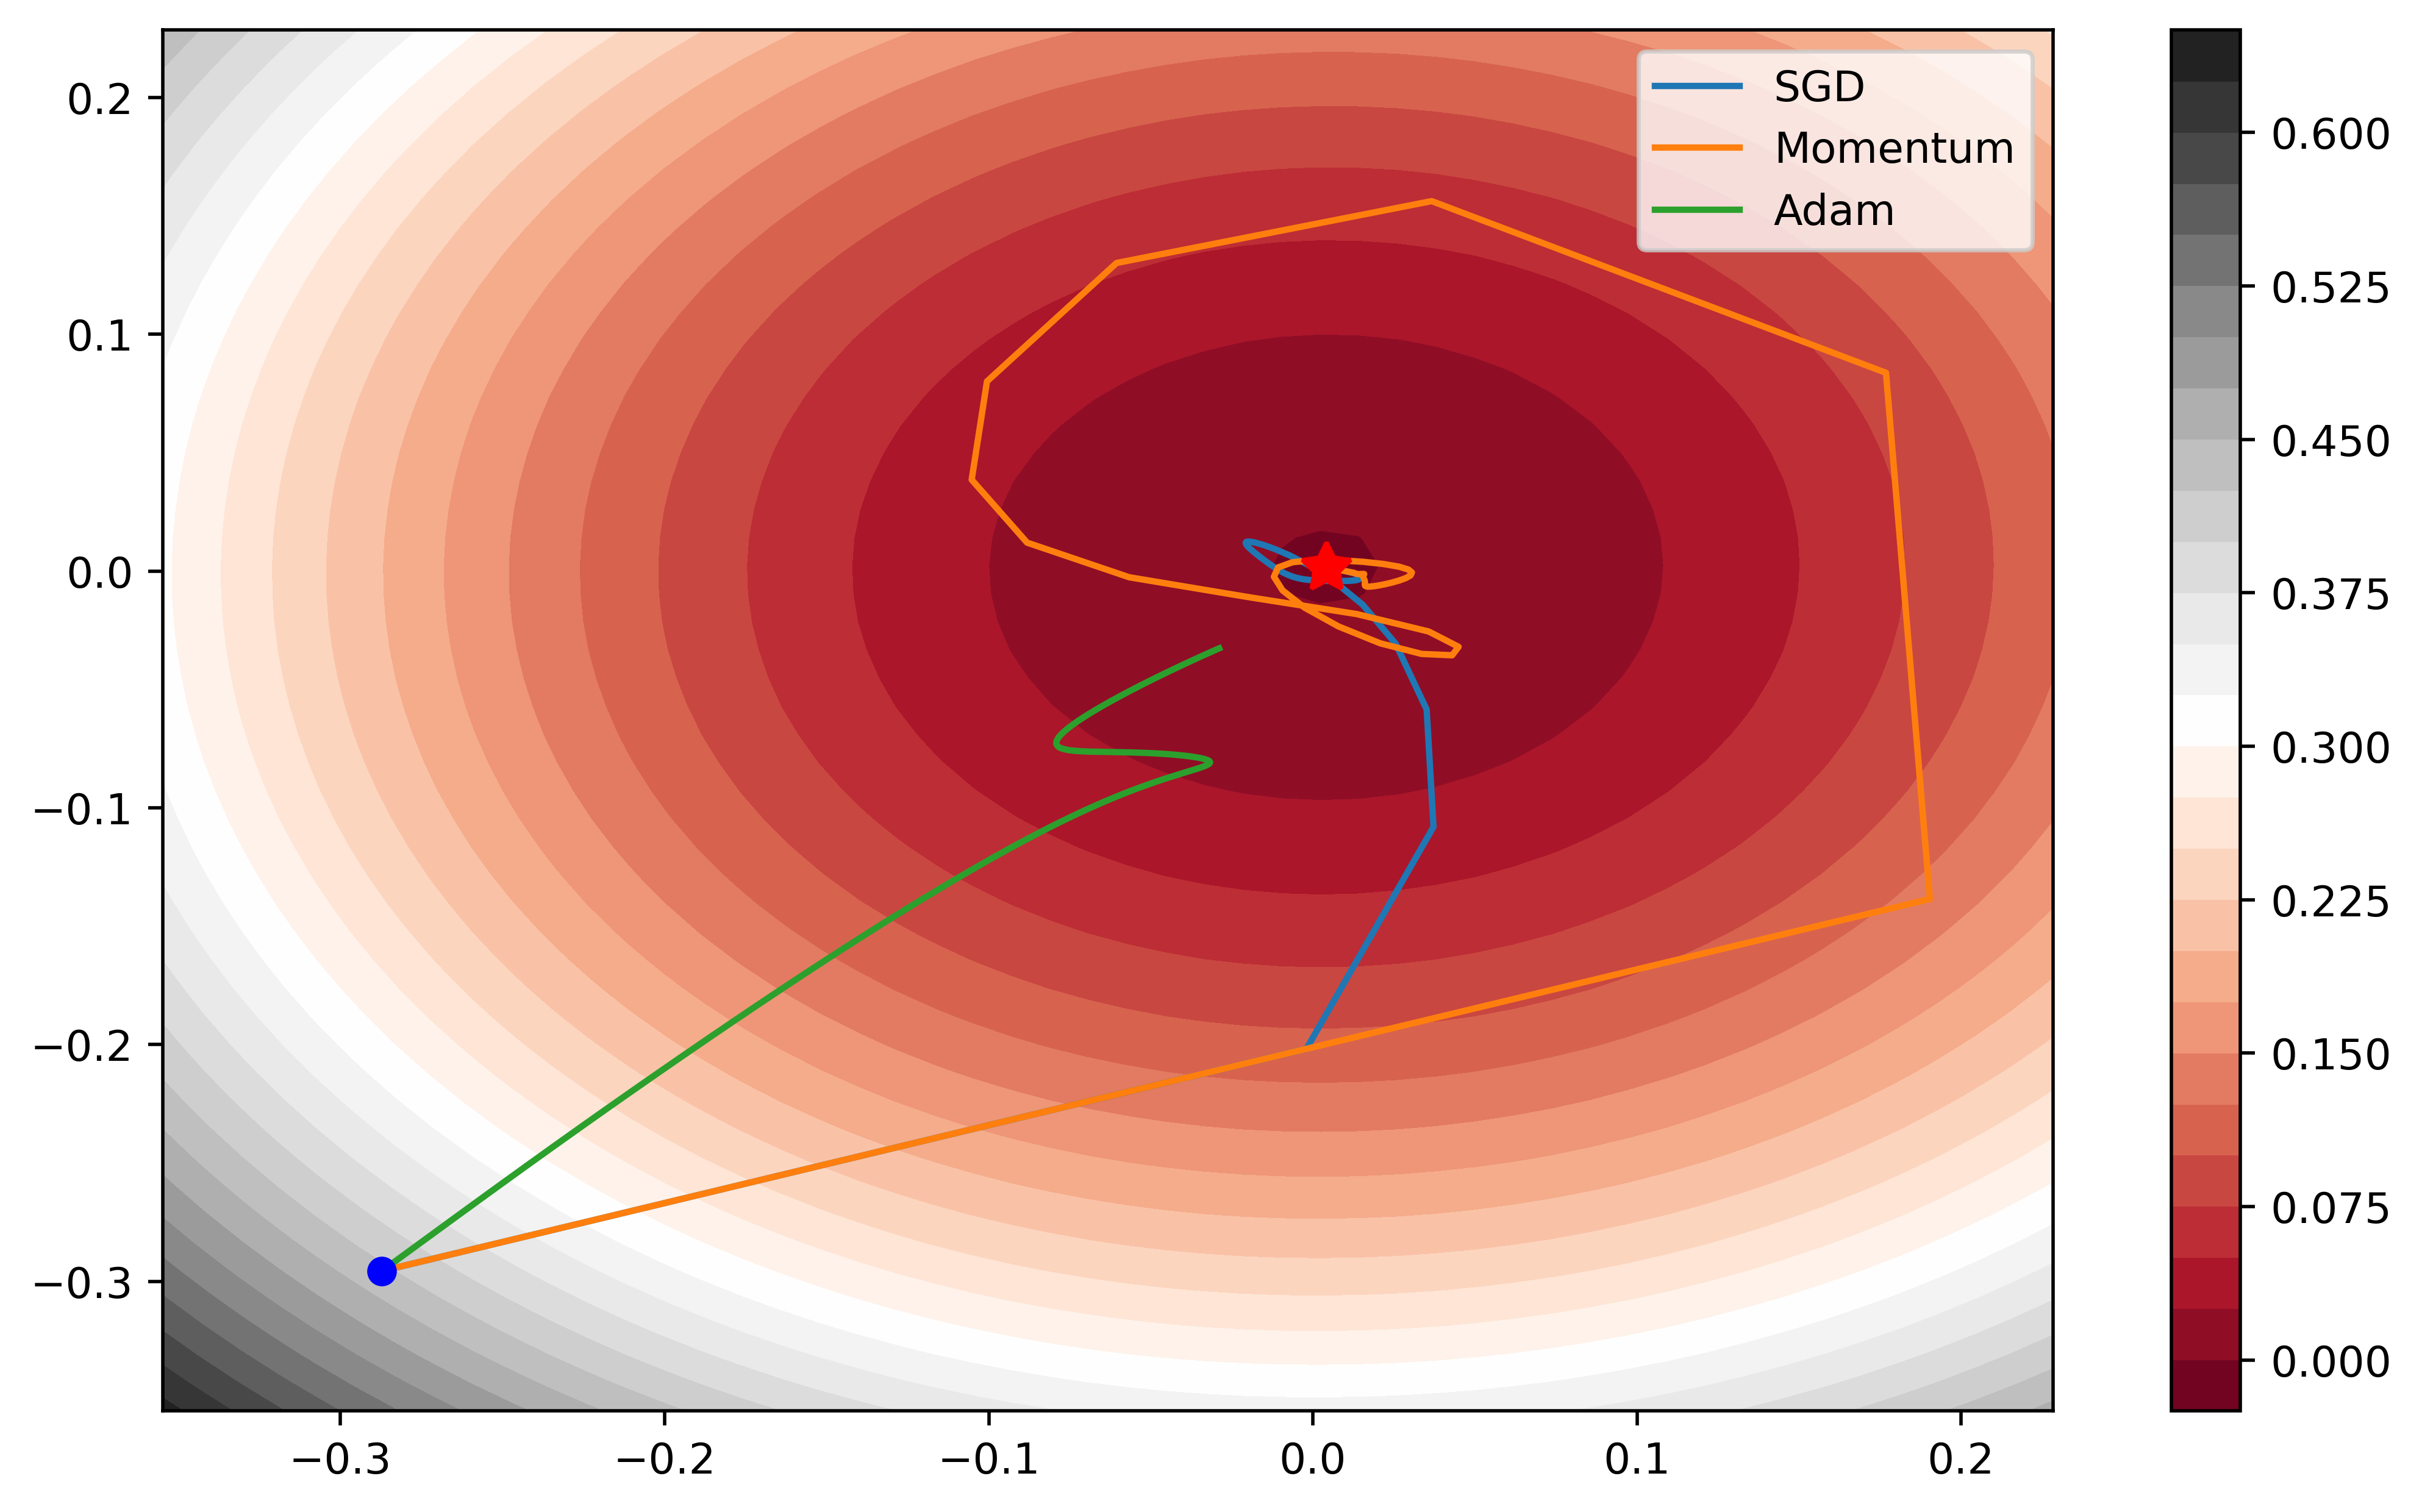

In [11]:
all_trajs = np.concatenate([sgd_quadratic_traj[:, :2], momentum_quadratic_traj[:, :2], adam_quadratic_traj[:, :2]])

minimum = all_trajs.min() - np.abs(all_trajs.min()) * 0.2
maximum = all_trajs.max() + np.abs(all_trajs.max()) * 0.2
X = np.linspace(minimum, maximum)
Y = np.linspace(minimum, maximum)

Z = np.empty((len(Y), len(X)))
for i in range(len(X)):
    for j in range(len(Y)):
        x = torch.tensor(optimal_x.copy())
        x[0] = X[i]
        x[1] = Y[j]
        Z[j, i] = obj_function(x)

plt.figure(figsize=(10, 6), dpi=500)
plt.contourf(X, Y, Z, 30, cmap='RdGy')
plt.colorbar()

plt.plot(sgd_quadratic_traj[:, 0], sgd_quadratic_traj[:, 1], label='SGD')
plt.plot(momentum_quadratic_traj[:, 0], momentum_quadratic_traj[:, 1], label='Momentum')
plt.plot(adam_quadratic_traj[:, 0], adam_quadratic_traj[:, 1], label='Adam')

plt.plot(sgd_quadratic_traj[0, 0], sgd_quadratic_traj[0, 1], 'bo')
plt.plot(optimal_x[0], optimal_x[1], marker=(5,1), color='red', markersize=12)
plt.legend()

plt.plot()
plt.show()

Rosenbrock function. The rosenbrock function is a nonconvex objective function commonly used to test optimization algorithms.

In [9]:
problem_size = 100
rosen_x0, rosen, rosen_optimal_x, rosen_optimal_value = benchmark.rosenbrock(problem_size)

rosen_iterations = 10000

Tune hyperparameters on the rosenbrock problem

In [10]:
rosen_tune = benchmark.tune_algos(
    rosen_x0,
    rosen,
    rosen_iterations,
    tune_iters=20,
    hyperparam_space={
        "lr": tune.loguniform(1e-7, 1),
        "momentum": tune.uniform(0.7, 1),
        "delta": tune.uniform(0, 40)
    },
    algos=["sgd", "momentum", "adam"]
)

print('Final hyperparam values:')
for algo, results in rosen_tune.items():
    print(f'  {algo}: ')
    for hp, val in results['hyperparams'].items():
        print(f'    {hp}: {val}')

100%|██████████| 3/3 [02:38<00:00, 52.97s/it]

Final hyperparam values:
  sgd: 
    lr: 2.380130098646003e-05
  momentum: 
    nesterov: True
    lr: 7.592984863757231e-07
    momentum: 0.7396346311134617
  adam: 
    lr: 0.12754656301404482


In [13]:
# SGD
sgd_rosen_vals, sgd_rosen_traj = benchmark.run_optimizer(
    torch.optim.SGD, rosen_x0, rosen, rosen_iterations, rosen_tune['sgd']['hyperparams'])
print(f'SGD optimality gap: {sgd_rosen_vals.min() - optimal_value}')

# Momentum
momentum_rosen_vals, momentum_rosen_traj = benchmark.run_optimizer(
    torch.optim.SGD, rosen_x0, rosen, rosen_iterations, rosen_tune['momentum']['hyperparams'])
print(f'Momentum optimality gap: {momentum_rosen_vals.min() - optimal_value}')

# Adam
adam_rosen_vals, adam_rosen_traj = benchmark.run_optimizer(
    torch.optim.Adam, rosen_x0, rosen, rosen_iterations, rosen_tune['adam']['hyperparams'])
print(f'Adam optimality gap: {adam_rosen_vals.min() - optimal_value}')

SGD optimality gap: 98.6612777201226
Momentum optimality gap: 99.24832148232963
Adam optimality gap: 0.000717112590191249


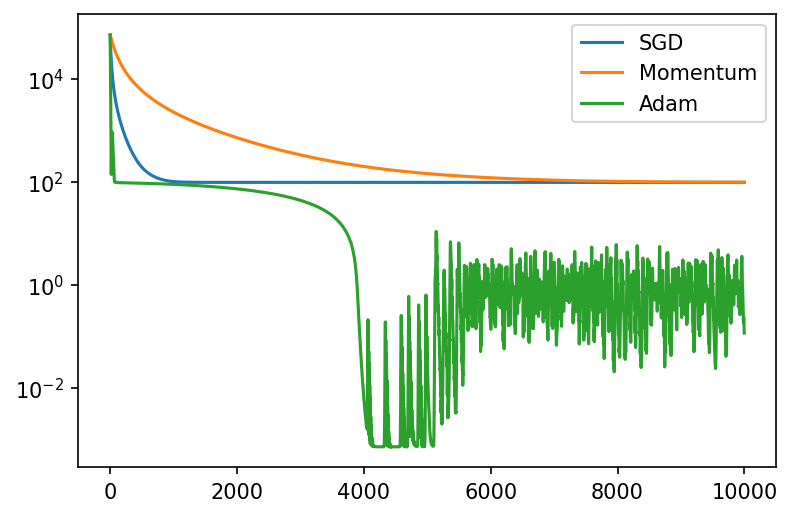

In [15]:
plt.figure(figsize=(6, 4), dpi=150)

plt.plot(sgd_rosen_vals - optimal_value, label='SGD')
plt.plot(momentum_rosen_vals - optimal_value, label='Momentum')
plt.plot(adam_rosen_vals - optimal_value, label='Adam')

plt.yscale('log')
plt.legend()
plt.show()

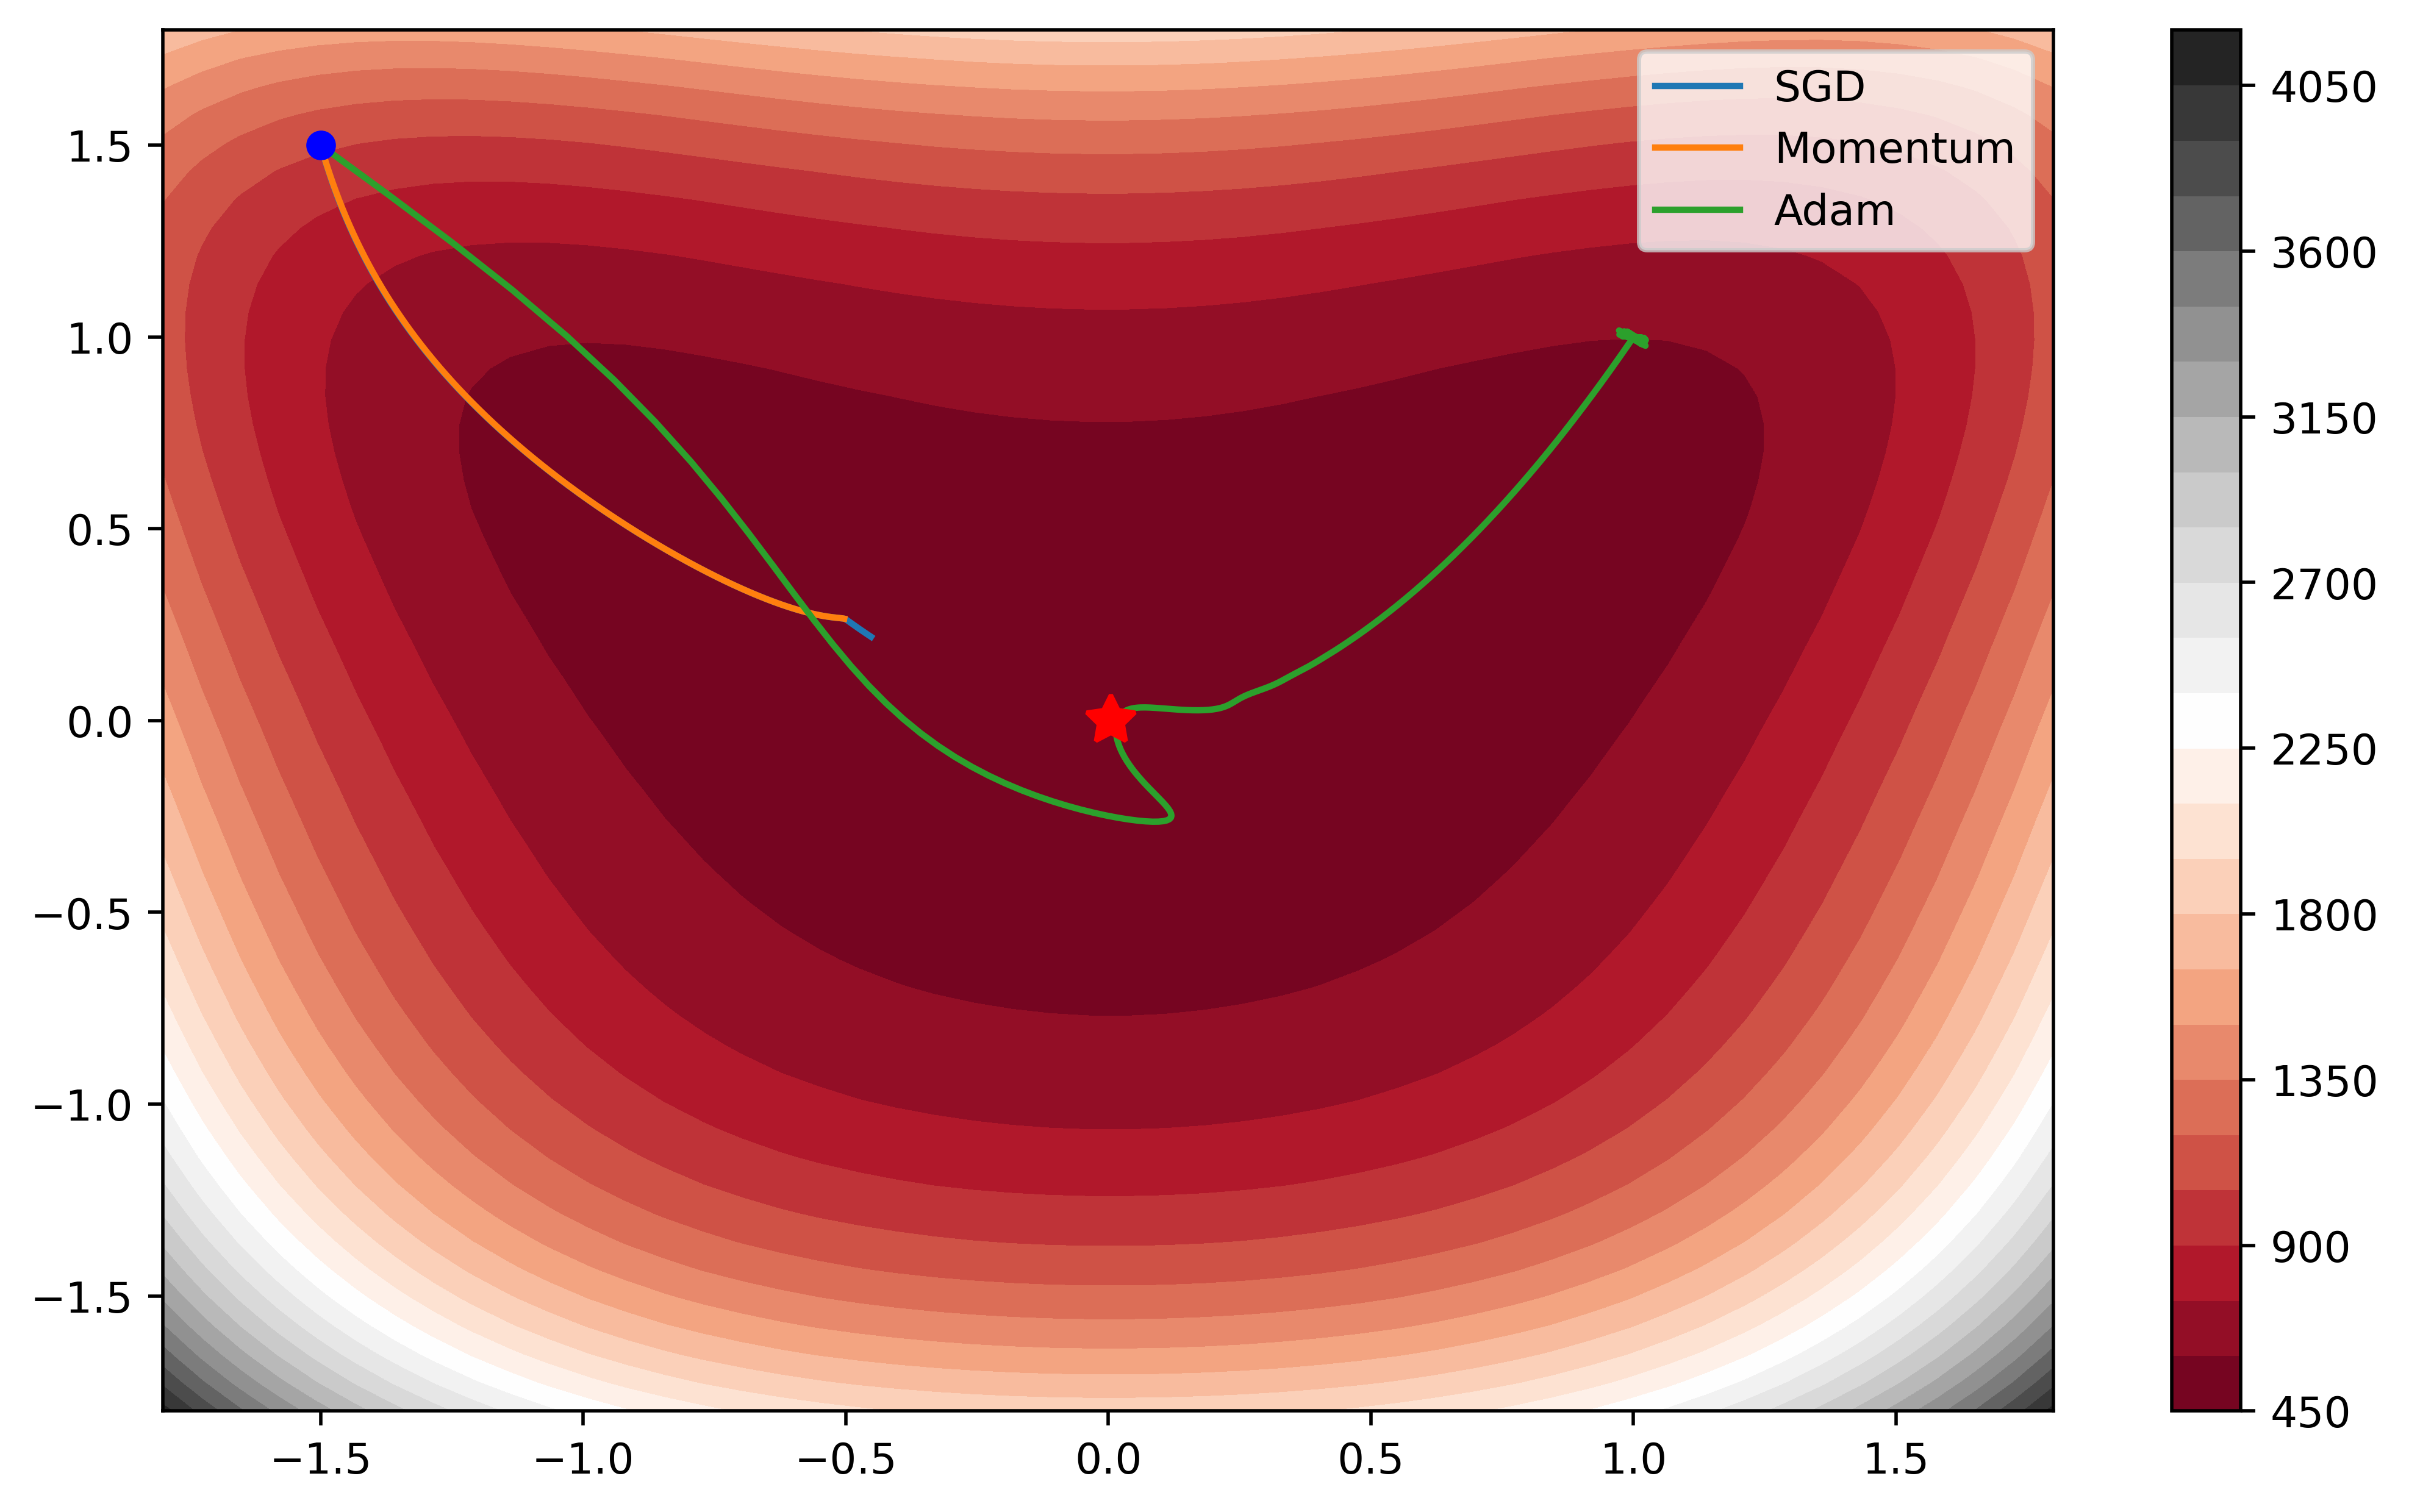

In [16]:
all_trajs = np.concatenate([sgd_rosen_traj[:, :2], momentum_rosen_traj[:, :2], adam_rosen_traj[:, :2]])

minimum = all_trajs.min() - np.abs(all_trajs.min()) * 0.2
maximum = all_trajs.max() + np.abs(all_trajs.max()) * 0.2
X = np.linspace(minimum, maximum)
Y = np.linspace(minimum, maximum)

Z = np.empty((len(Y), len(X)))
for i in range(len(X)):
    for j in range(len(Y)):
        x = torch.tensor(optimal_x.copy())
        x[0] = X[i]
        x[1] = Y[j]
        Z[j, i] = rosen(x)

plt.figure(figsize=(10, 6), dpi=500)
plt.contourf(X, Y, Z, 30, cmap='RdGy')
plt.colorbar()

plt.plot(sgd_rosen_traj[:, 0], sgd_rosen_traj[:, 1], label='SGD')
plt.plot(momentum_rosen_traj[:, 0], momentum_rosen_traj[:, 1], label='Momentum')
plt.plot(adam_rosen_traj[:, 0], adam_rosen_traj[:, 1], label='Adam')

plt.plot(sgd_rosen_traj[0, 0], sgd_rosen_traj[0, 1], 'bo')
plt.plot(optimal_x[0], optimal_x[1], marker=(5,1), color='red', markersize=12)
plt.legend()

plt.plot()
plt.show()

# TODO

In [ ]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines import PPO2

In [ ]:
dataset = [benchmark.convex_quadratic() for _ in range(90)]

In [ ]:
env = autonomous_optimizer.Environment(dataset, num_steps=40, history_len=25)

In [ ]:
model = PPO2(MlpPolicy, env, n_steps=8, verbose=0, tensorboard_log='tb_logs')

In [160]:
%load_ext tensorboard
%tensorboard --logdir tb_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 18570), started 0:39:36 ago. (Use '!kill 18570' to kill it.)

In [ ]:
model.learn(total_timesteps=20 * 40 * 90)

In [163]:
ao_quadratic_vals, ao_quadratic_traj = benchmark.run_optimizer(
    autonomous_optimizer.AutonomousOptimizer, problem, 40, {"policy": model})
print(f'Autonomous Optimizer optimality gap: {ao_quadratic_vals.min()}')

Autonomous Optimizer optimality gap: 0.33430740237236023


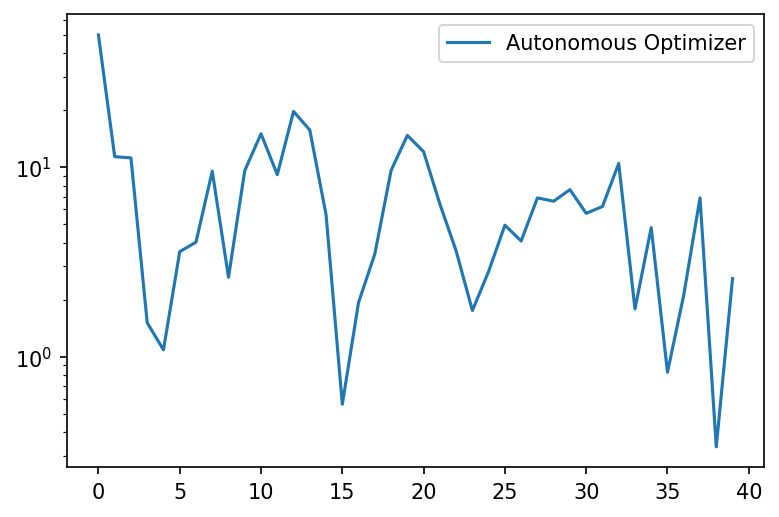

In [164]:
plt.figure(figsize=(6, 4), dpi=150)

#plt.plot(sgd_quadratic_vals - optimal_value, label='SGD')
#plt.plot(momentum_quadratic_vals - optimal_value, label='Momentum')
plt.plot(ao_quadratic_vals, label='Autonomous Optimizer')

plt.yscale('log')
plt.legend()
plt.show()